In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd '/content/drive/My Drive/Fall 2020/1006 Capstone/NYU_Team18_Accern_Capstone_Fall2020/'

/content/drive/My Drive/Fall 2020/1006 Capstone/NYU_Team18_Accern_Capstone_Fall2020


In [3]:
!pip install transformers
!pip install pytorch-lightning==1.0.8

In [4]:
import numpy as np
import pandas as pd
import torch

from read_data import *
from FinSentiment import *

if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


### Train on Correct

In [5]:
pretrained_bert_name = 'distilbert-base-cased'
incorrect_type = 'correct'
company_embedding_method = 'sum_embedding'
company_weight = 1
burn_in_epochs = 2
max_epochs = burn_in_epochs + 4
existing_company_only = True

model_name = '_'.join([pretrained_bert_name, incorrect_type, company_embedding_method, f'cpy_wt{company_weight}'])

#############################################################################################
tokenizer = DistilBertTokenizer.from_pretrained(pretrained_bert_name)
(train_ids,X_train,y_train), (val_ids,X_val,y_val), (test_ids,X_test,y_test), _ = read_data(incorrect_type, dir_path='data/', existing_company_only=existing_company_only, sample=None)

X_train = np.concatenate([X_train, X_val])
y_train = np.concatenate([y_train, y_val])
train_ids = np.concatenate([train_ids, val_ids])

train_dataloader = tokenize_and_dataloader(X_train, y_train, tokenizer, train_ids, 16, 4, random=True)
val_dataloader = tokenize_and_dataloader(X_test, y_test, tokenizer, test_ids, 16, 4, random=False)

#############################################################################################
model = FinSentiment(pretrained_bert_name, incorrect_type, company_embedding_method, company_weight, 
                     lr=5e-5, hidden_dropout_prob=0.1, discriminate=True, burn_in_epochs=burn_in_epochs)

logger = TensorBoardLogger('experiments/logs', name=model_name)
checkpoint_callback = ModelCheckpoint(
    filepath = 'experiments/saved_models/' + company_embedding_method + '/' + model_name + '/' + model_name,
    monitor='val_loss',
    mode='min',
    save_top_k=1,
    save_last=True,
    verbose=False
)
trainer = pl.Trainer(progress_bar_refresh_rate=20, gpus=1, max_epochs=max_epochs, logger=logger, callbacks=[checkpoint_callback], fast_dev_run=False)
trainer.fit(model, train_dataloader, val_dataloader)

trainer.save_checkpoint('experiments/saved_models/' + model_name + '/' + model_name + '_last.ckpt')

[PROGRESS] Saving hyperparameters
[PROGRESS] Initializing BERT model


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[PROGRESS] Initializing Company Embedding Layer
[PROGRESS] Initializing classifier
[PROGRESS] Done initialization



  | Name          | Type            | Params
--------------------------------------------------
0 | bert          | DistilBertModel | 65.2 M
1 | company_layer | Embedding       | 807 K 
2 | classifier    | Sequential      | 594 K 
3 | pooler        | BertPooler      | 590 K 
4 | dropout       | Dropout         | 0     


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: RuntimeWarning: You have set 5 number of classes which is different from predicted (3) and target (4) number of classes
  warnings.warn(*args, **kwargs)


[PROGRESS] Burning in classifier epoch 0


[PROGRESS] Burning in classifier epoch 1


Saving latest checkpoint...


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: RuntimeWarning: You have set 5 number of classes which is different from predicted (14) and target (5) number of classes
  warnings.warn(*args, **kwargs)


[MODEL NAME]: distilbert-base-cased_correct_sum_embedding 	 [INCORRECT TYPE]: correct
RESULTS:
	Accuracy: 		0.9218
	Weighted Accuracy: 	0.9458
	F1 Score: 		0.9218
	AUC_SCORE[CLS 0]: 	0.9981
	AUC_SCORE[CLS 1]: 	0.9835
	AUC_SCORE[CLS 2]: 	0.9561
	AUC_SCORE[CLS 3]: 	0.9497
	AUC_SCORE[CLS 4]: 	0.9986

Confusion Matrix


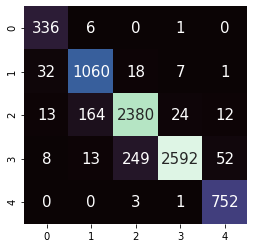

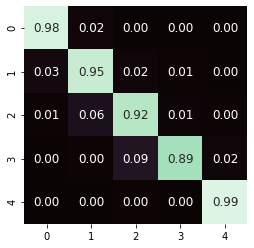

--------------------------------------------------------------------------------



[MODEL NAME]: distilbert-base-cased_correct_sum_embedding 	 [INCORRECT TYPE]: inverse
RESULTS:
	Accuracy: 		0.8156
	Weighted Accuracy: 	0.7858
	F1 Score: 		0.8156
	AUC_SCORE[CLS 0]: 	0.7806
	AUC_SCORE[CLS 1]: 	0.7480
	AUC_SCORE[CLS 2]: 	0.9485
	AUC_SCORE[CLS 3]: 	0.8572
	AUC_SCORE[CLS 4]: 	0.9146

Confusion Matrix


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: RuntimeWarning: You have set 5 number of classes which is different from predicted (14) and target (5) number of classes
  warnings.warn(*args, **kwargs)


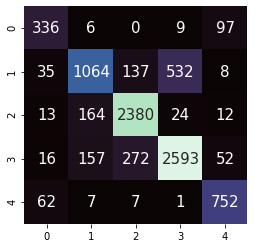

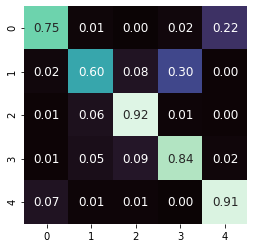

--------------------------------------------------------------------------------



[MODEL NAME]: distilbert-base-cased_correct_sum_embedding 	 [INCORRECT TYPE]: boundary
	Boundary Accuracy: 		0.8461
	Drop Total Sample: 		829.0000
--------------------------------------------------------------------------------



In [6]:
evaluate_model(model, tokenizer, trainer, existing_company_only=True, dir_path='data/',batch_size=16, num_workers=4)

### Train on Inverse

In [7]:
pretrained_bert_name = 'distilbert-base-cased'
incorrect_type = 'inverse'
company_embedding_method = 'sum_embedding'
company_weight = 1
burn_in_epochs = 2
max_epochs = burn_in_epochs + 4
existing_company_only = True

model_name = '_'.join([pretrained_bert_name, incorrect_type, company_embedding_method, f'cpy_wt{company_weight}'])

#############################################################################################
tokenizer = DistilBertTokenizer.from_pretrained(pretrained_bert_name)
(train_ids,X_train,y_train), (val_ids,X_val,y_val), (test_ids,X_test,y_test), _ = read_data(incorrect_type, dir_path='data/', existing_company_only=existing_company_only, sample=None)

X_train = np.concatenate([X_train, X_val])
y_train = np.concatenate([y_train, y_val])
train_ids = np.concatenate([train_ids, val_ids])

train_dataloader = tokenize_and_dataloader(X_train, y_train, tokenizer, train_ids, 16, 4, random=True)
val_dataloader = tokenize_and_dataloader(X_test, y_test, tokenizer, test_ids, 16, 4, random=False)

#############################################################################################
model = FinSentiment(pretrained_bert_name, incorrect_type, company_embedding_method, company_weight, 
                     lr=5e-5, hidden_dropout_prob=0.1, discriminate=True, burn_in_epochs=burn_in_epochs)

logger = TensorBoardLogger('experiments/logs', name=model_name)
checkpoint_callback = ModelCheckpoint(
    filepath = 'experiments/saved_models/' + company_embedding_method + '/' + model_name + '/' + model_name,
    monitor='val_loss',
    mode='min',
    save_top_k=1,
    save_last=True,
    verbose=False
)
trainer = pl.Trainer(progress_bar_refresh_rate=20, gpus=1, max_epochs=max_epochs, logger=logger, callbacks=[checkpoint_callback], fast_dev_run=False)
trainer.fit(model, train_dataloader, val_dataloader)

trainer.save_checkpoint('experiments/saved_models/' + model_name + '/' + model_name + '_last.ckpt')

[PROGRESS] Saving hyperparameters
[PROGRESS] Initializing BERT model


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[PROGRESS] Initializing Company Embedding Layer
[PROGRESS] Initializing classifier
[PROGRESS] Done initialization



  | Name          | Type            | Params
--------------------------------------------------
0 | bert          | DistilBertModel | 65.2 M
1 | company_layer | Embedding       | 807 K 
2 | classifier    | Sequential      | 594 K 
3 | pooler        | BertPooler      | 590 K 
4 | dropout       | Dropout         | 0     


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: RuntimeWarning: You have set 5 number of classes which is different from predicted (2) and target (4) number of classes
  warnings.warn(*args, **kwargs)


[PROGRESS] Burning in classifier epoch 0


[PROGRESS] Burning in classifier epoch 1


Saving latest checkpoint...


[MODEL NAME]: distilbert-base-cased_inverse_sum_embedding 	 [INCORRECT TYPE]: correct
RESULTS:
	Accuracy: 		0.9287
	Weighted Accuracy: 	0.9423
	F1 Score: 		0.9287
	AUC_SCORE[CLS 0]: 	0.9935
	AUC_SCORE[CLS 1]: 	0.9560
	AUC_SCORE[CLS 2]: 	0.9665
	AUC_SCORE[CLS 3]: 	0.9767
	AUC_SCORE[CLS 4]: 	0.9988

Confusion Matrix


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: RuntimeWarning: You have set 5 number of classes which is different from predicted (9) and target (5) number of classes
  warnings.warn(*args, **kwargs)


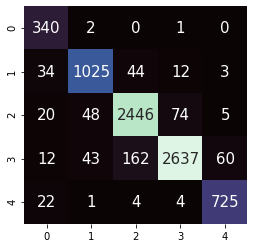

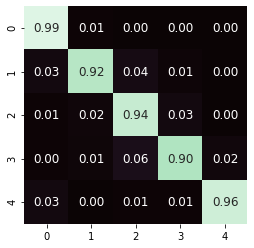

--------------------------------------------------------------------------------



[MODEL NAME]: distilbert-base-cased_inverse_sum_embedding 	 [INCORRECT TYPE]: inverse
RESULTS:
	Accuracy: 		0.9056
	Weighted Accuracy: 	0.9174
	F1 Score: 		0.9056
	AUC_SCORE[CLS 0]: 	0.9915
	AUC_SCORE[CLS 1]: 	0.9467
	AUC_SCORE[CLS 2]: 	0.9698
	AUC_SCORE[CLS 3]: 	0.9624
	AUC_SCORE[CLS 4]: 	0.9952

Confusion Matrix


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: RuntimeWarning: You have set 5 number of classes which is different from predicted (9) and target (5) number of classes
  warnings.warn(*args, **kwargs)


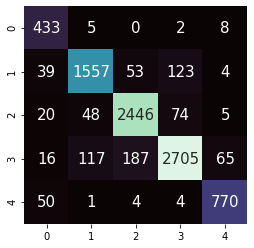

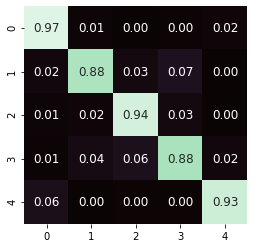

--------------------------------------------------------------------------------



[MODEL NAME]: distilbert-base-cased_inverse_sum_embedding 	 [INCORRECT TYPE]: boundary
	Boundary Accuracy: 		0.9196
	Drop Total Sample: 		648.0000
--------------------------------------------------------------------------------



In [8]:
evaluate_model(model, tokenizer, trainer, existing_company_only=True, dir_path='data/',batch_size=16, num_workers=4)

### Train on Boundary

In [9]:
pretrained_bert_name = 'distilbert-base-cased'
incorrect_type = 'boundary'
company_embedding_method = 'sum_embedding'
company_weight = 1
burn_in_epochs = 2
max_epochs = burn_in_epochs + 4
existing_company_only = True

model_name = '_'.join([pretrained_bert_name, incorrect_type, company_embedding_method, f'cpy_wt{company_weight}'])

#############################################################################################
tokenizer = DistilBertTokenizer.from_pretrained(pretrained_bert_name)
(train_ids,X_train,y_train), (val_ids,X_val,y_val), (test_ids,X_test,y_test), _ = read_data(incorrect_type, dir_path='data/', existing_company_only=existing_company_only, sample=None)

X_train = np.concatenate([X_train, X_val])
y_train = np.concatenate([y_train, y_val])
train_ids = np.concatenate([train_ids, val_ids])

train_dataloader = tokenize_and_dataloader(X_train, y_train, tokenizer, train_ids, 16, 4, random=True)
val_dataloader = tokenize_and_dataloader(X_test, y_test, tokenizer, test_ids, 16, 4, random=False)

#############################################################################################
model = FinSentiment(pretrained_bert_name, incorrect_type, company_embedding_method, company_weight, 
                     lr=5e-5, hidden_dropout_prob=0.1, discriminate=True, burn_in_epochs=burn_in_epochs)

logger = TensorBoardLogger('experiments/logs', name=model_name)
checkpoint_callback = ModelCheckpoint(
    filepath = 'experiments/saved_models/' + company_embedding_method + '/' + model_name + '/' + model_name,
    monitor='val_loss',
    mode='min',
    save_top_k=1,
    save_last=True,
    verbose=False
)
trainer = pl.Trainer(progress_bar_refresh_rate=20, gpus=1, max_epochs=max_epochs, logger=logger, callbacks=[checkpoint_callback], fast_dev_run=False)
trainer.fit(model, train_dataloader, val_dataloader)

trainer.save_checkpoint('experiments/saved_models/' + model_name + '/' + model_name + '_last.ckpt')

[PROGRESS] Saving hyperparameters
[PROGRESS] Initializing BERT model


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type            | Params
--------------------------------------------------
0 | bert          | DistilBertModel | 65.2 M
1 | company_layer | Embedding       | 807 K 
2 | classifier    | Sequential      | 594 K 
3 | pooler        | BertPooler      | 590 K 
4 | dropout       | Dropout         | 0     


[PROGRESS] Initializing Company Embedding Layer
[PROGRESS] Initializing classifier
[PROGRESS] Done initialization


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: RuntimeWarning: You have set 5 number of classes which is different from predicted (2) and target (4) number of classes
  warnings.warn(*args, **kwargs)


[PROGRESS] Burning in classifier epoch 0


[PROGRESS] Burning in classifier epoch 1


Saving latest checkpoint...


[MODEL NAME]: distilbert-base-cased_boundary_sum_embedding 	 [INCORRECT TYPE]: correct
RESULTS:
	Accuracy: 		0.9332
	Weighted Accuracy: 	0.9338
	F1 Score: 		0.9332
	AUC_SCORE[CLS 0]: 	0.9943
	AUC_SCORE[CLS 1]: 	0.9905
	AUC_SCORE[CLS 2]: 	0.9709
	AUC_SCORE[CLS 3]: 	0.9807
	AUC_SCORE[CLS 4]: 	0.9947

Confusion Matrix


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: RuntimeWarning: You have set 5 number of classes which is different from predicted (7) and target (5) number of classes
  warnings.warn(*args, **kwargs)


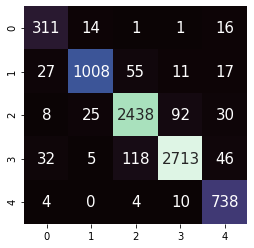

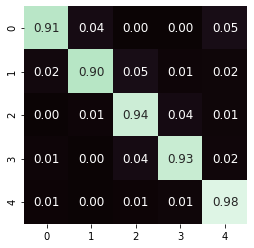

--------------------------------------------------------------------------------



[MODEL NAME]: distilbert-base-cased_boundary_sum_embedding 	 [INCORRECT TYPE]: inverse
RESULTS:
	Accuracy: 		0.8360
	Weighted Accuracy: 	0.8180
	F1 Score: 		0.8360
	AUC_SCORE[CLS 0]: 	0.9634
	AUC_SCORE[CLS 1]: 	0.9779
	AUC_SCORE[CLS 2]: 	0.9741
	AUC_SCORE[CLS 3]: 	0.9715
	AUC_SCORE[CLS 4]: 	0.9849

Confusion Matrix


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: RuntimeWarning: You have set 5 number of classes which is different from predicted (7) and target (5) number of classes
  warnings.warn(*args, **kwargs)


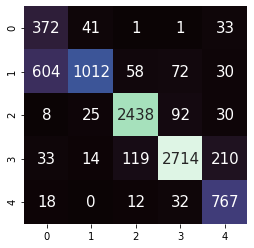

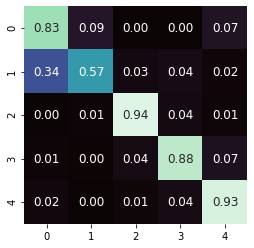

--------------------------------------------------------------------------------



[MODEL NAME]: distilbert-base-cased_boundary_sum_embedding 	 [INCORRECT TYPE]: boundary
	Boundary Accuracy: 		0.9665
	Drop Total Sample: 		407.0000
--------------------------------------------------------------------------------



In [10]:
evaluate_model(model, tokenizer, trainer, existing_company_only=True, dir_path='data/',batch_size=16, num_workers=4)